In [5]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import pickle
import pandas as pd
import numpy as np
from psm_causal_effects import psm_causal_effects

# read data
with open('data.dat') as f:
    data, subjects = pickle.load(f)
f.close()

# adding subject ids
for i in range(len(data)):
    data[i]['subject'] = pd.Series(np.repeat(subjects[i],data[i].shape[0],axis=0), index=data[i].index, dtype=str)

del subjects

# concatenatig into a single dataframe
data_all = pd.concat(data, axis=0)
data_all = data_all.reset_index(drop=True)

# keeping only relevant variables
data_all = data_all[['subject','mood','quality','mood_prev']]#,'stress_prev','daytype']]

# removing nan rows
data_all = data_all.dropna()
data_all = data_all.reset_index(drop=True)

# load assessments
with open('../CS120/Assessment/assessment.dat') as f:
    ass = pickle.load(f)
f.close()

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    mood       
No. Observations:      9162       Method:                REML       
No. Groups:            207        Scale:                 0.7389     
Min. group size:       4          Likelihood:            -12427.6499
Max. group size:       133        Converged:             Yes        
Mean group size:       44.3                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  3.283    0.114 28.782 0.000  3.059  3.506
quality                    0.383    0.073  5.282 0.000  0.241  0.525
Intercept RE               1.724    0.115                           
Intercept RE x quality RE -0.993    0.003                           
quality RE                 0.810    0.071        

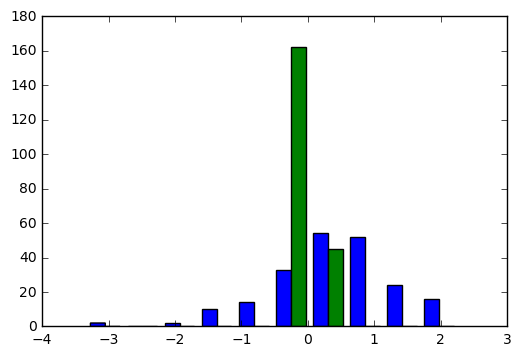

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

md = smf.mixedlm('mood ~ quality', data_all, groups=data_all['subject'], re_formula="~quality")
mdf = md.fit() 
print mdf.summary()

RE = np.array(mdf.random_effects)

plt.hist(RE,10);



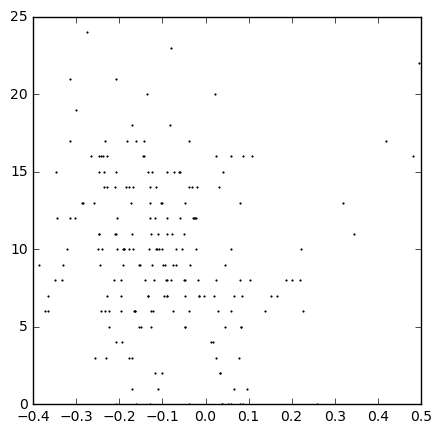

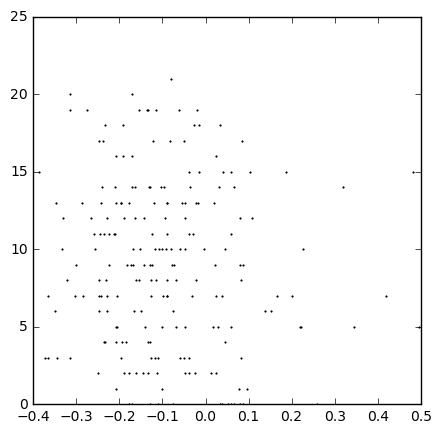

In [5]:
subjects = np.unique(data_all['subject'])
plt.figure(figsize=[5,5])
ind = np.zeros(subjects.size)
for i, subj in enumerate(subjects):
    ind[i] = np.where(ass['ID']==subj)[0]
    plt.plot(RE[i,1], np.nanmean(ass.loc[ind[i],'PHQ9 W0']), '.', markersize=2, color=(0,0,0))
plt.figure(figsize=[5,5])
for i, subj in enumerate(subjects):
    plt.plot(RE[i,1], np.nanmean(ass.loc[ind[i],'GAD7 W0']), '.', markersize=2, color=(0,0,0))

In [6]:
md = smf.mixedlm('quality ~ mood_prev', data_all, groups=data_all['subject'], re_formula="~mood_prev")
mdf = md.fit() 
print mdf.summary()
RE = np.array(mdf.random_effects)


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     quality    
No. Observations:      9162        Method:                 REML       
No. Groups:            207         Scale:                  1.6962     
Min. group size:       4           Likelihood:             -15805.4807
Max. group size:       133         Converged:              Yes        
Mean group size:       44.3                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    3.174    0.115 27.586 0.000  2.948  3.399
mood_prev                    0.254    0.019 13.123 0.000  0.216  0.293
Intercept RE                 1.183    0.234                           
Intercept RE x mood_prev RE -0.072    0.036                           
mood_prev RE          

[[ 1.         -0.19200033]
 [-0.19200033  1.        ]]


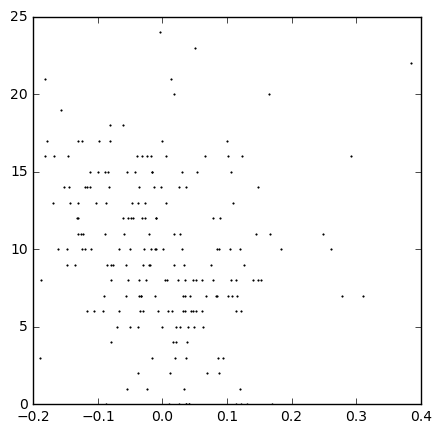

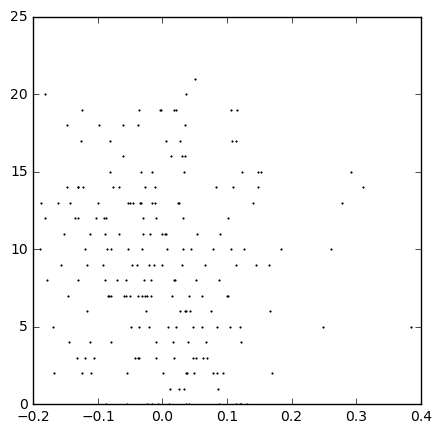

In [7]:
subjects = np.unique(data_all['subject'])
plt.figure(figsize=[5,5])
ind = np.zeros(subjects.size)
phq = np.zeros(subjects.size)
for i, subj in enumerate(subjects):
    ind[i] = np.where(ass['ID']==subj)[0]
    phq[i] = np.nanmean(ass.loc[ind[i],'PHQ9 W0'])
plt.plot(RE[:,1], phq, '.', markersize=2, color=(0,0,0))
print np.corrcoef(RE[:,1], phq)
plt.figure(figsize=[5,5])
for i, subj in enumerate(subjects):
    plt.plot(RE[i,1], np.nanmean(ass.loc[ind[i],'GAD7 W0']), '.', markersize=2, color=(0,0,0))

In [6]:
# calculating personal model parameters

betas_m2s = np.zeros([len(data),2])
betas_s2m = np.zeros([len(data),2])
for iSubj in range(len(data)):
    if data[iSubj].shape[0] ==0:
        betas_m2s[iSubj, :] = np.array([np.nan, np.nan])
        betas_s2m[iSubj, :] = np.array([np.nan, np.nan])
    else:
        md = smf.glm('quality ~ mood_prev', data[iSubj])
        mdf = md.fit()
        betas_m2s[iSubj, :] = mdf.params
        md = smf.glm('mood ~ quality', data[iSubj])
        mdf = md.fit()
        betas_s2m[iSubj, :] = mdf.params
    


                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 9162
Model:                            GLM   Df Residuals:                     9160
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                   2.43703683005
Method:                          IRLS   Log-Likelihood:                -17080.
Date:                Tue, 07 Mar 2017   Deviance:                       22323.
Time:                        16:02:12   Pearson chi2:                 2.23e+04
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2433      0.057     21.701      0.000         1.131     1.356
mood_prev      0.6411      0.011     58.684      0.0

(0, 8)

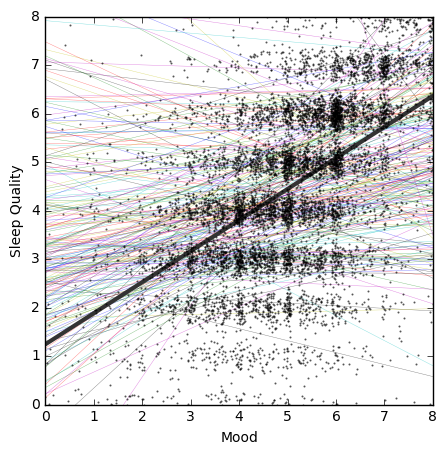

In [9]:
md = smf.glm('quality ~ mood_prev', data_all)
mdf = md.fit()
print mdf.summary()

plt.figure(figsize=[5,5])
for iSubj in range(len(data)):
    plt.plot([0,8], [betas_m2s[iSubj, 0],betas_m2s[iSubj,0]+betas_m2s[iSubj,1]*8], linewidth=.3, alpha=.5)
plt.plot([0,8], [mdf.params[0],mdf.params[0]+mdf.params[1]*8], color=(.2, .2,.2), linewidth=3)
plt.plot(data_all['mood_prev']+0.075*np.random.randn(data_all.shape[0]),data_all['quality']+0.2*np.random.randn(data_all.shape[0]),'.',markersize=2,\
        color=(0,0,0),alpha=.5)
plt.xlabel('Mood')
plt.ylabel('Sleep Quality')
plt.xlim([0,8])
plt.ylim([0,8])
# plt.box()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   mood   No. Observations:                 9162
Model:                            GLM   Df Residuals:                     9160
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                    1.3978506634
Method:                          IRLS   Log-Likelihood:                -14534.
Date:                Tue, 07 Mar 2017   Deviance:                       12804.
Time:                        16:02:23   Pearson chi2:                 1.28e+04
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.8314      0.033     86.950      0.000         2.768     2.895
quality        0.4940      0.007     73.222      0.0

(0, 8)

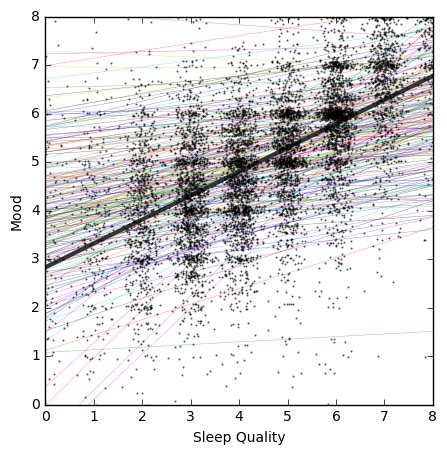

In [10]:
md = smf.glm('mood ~ quality', data_all)
mdf = md.fit()
print mdf.summary()

plt.figure(figsize=[5,5])
for iSubj in range(len(data)):
    plt.plot([0,8], [betas_s2m[iSubj, 0],betas_s2m[iSubj,0]+betas_s2m[iSubj,1]*8], linewidth=.3, alpha=.5)
plt.plot([0,8], [mdf.params[0],mdf.params[0]+mdf.params[1]*8], color=(.2,.2,.2), linewidth=3)
plt.plot(data_all['quality']+0.2*np.random.randn(data_all.shape[0]),data_all['mood']+0.075*np.random.randn(data_all.shape[0]),'.',markersize=2,\
        color=(0,0,0),alpha=.5)
plt.xlabel('Sleep Quality')
plt.ylabel('Mood')
plt.xlim([0,8])
plt.ylim([0,8])



/usr/local/lib/python2.7/dist-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


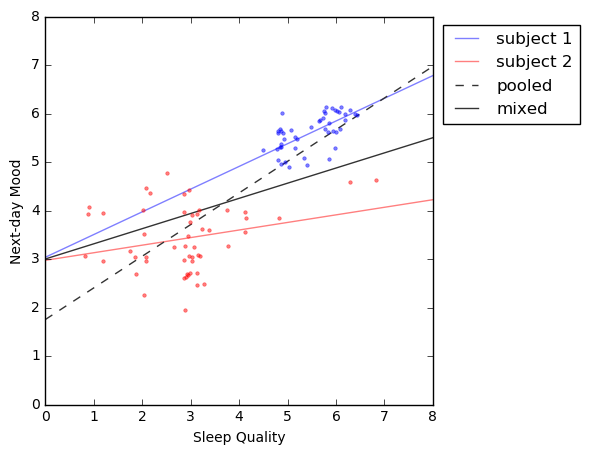

In [9]:
from psm_causal_effects import psm_causal_effects
import matplotlib.pyplot as plt
%matplotlib inline

ind1 = 40
ind2 = 140

plt.figure(figsize=[5,5])
plt.plot([0,8], [betas_s2m[ind1, 0],betas_s2m[ind1,0]+betas_s2m[ind1,1]*8], linewidth=1, alpha=.5, color=(0,0,1))
plt.plot([0,8], [betas_s2m[ind2, 0],betas_s2m[ind2,0]+betas_s2m[ind2,1]*8], linewidth=1, alpha=.5, color=(1,0,0))
#plt.plot([0,8], [mdf.params[0],mdf.params[0]+mdf.params[1]*8], color=(.2,.2,.2), linewidth=1)

data_2  = pd.concat([data[ind1], data[ind2]],axis=0)
data_2 = data_2[['subject','mood','quality','mood_prev','daytype']]
data_2 = data_2.dropna()
data_2 = data_2.reset_index(drop=True)

#pooled regression
md = smf.glm('mood ~ quality', data_2)
mdf = md.fit()
plt.plot([0,8], [mdf.params[0],mdf.params[0]+mdf.params[1]*8], color=(.2,.2,.2), linewidth=1, linestyle='--')

#mixed linear models regression
# md = smf.mixedlm('quality ~ mood_prev', data_2, groups=data_2['subject'], re_formula="~mood_prev")
md = smf.mixedlm('mood ~ quality', data_2, groups=data_2['subject'], re_formula="~quality")
mdf = md.fit() 
plt.plot([0,8], [mdf.params[0],mdf.params[0]+mdf.params[1]*8], color=(.2,.2,.2), linewidth=1)

#psm
# coef = psm_causal_effects(treatment=data_2['quality'], outcome=data_2['mood'], confound=['mood_prev','stress_prev','daytype'], scorefun='unmatched', output='linear')

plt.xlabel('Sleep Quality')
plt.ylabel('Next-day Mood')
plt.xlim([0,8])
plt.ylim([0,8])

plt.legend(['subject 1','subject 2','pooled','mixed'],bbox_to_anchor=(1.4, 1))

plt.plot(data[ind1]['quality']+0.2*np.random.randn(data[ind1].shape[0]),data[ind1]['mood']+0.075*np.random.randn(data[ind1].shape[0]),'.',markersize=5,\
        color=(0,0,1),alpha=.5)
plt.plot(data[ind2]['quality']+0.2*np.random.randn(data[ind2].shape[0]),data[ind2]['mood']+0.075*np.random.randn(data[ind2].shape[0]),'.',markersize=5,\
        color=(1,0,0),alpha=.5)
# plt.box('off')


In [9]:
coefs

array([[ 0.63932496]])

In [63]:
mdf.params


Intercept       1.643505
mood_prev       0.538008
Intercept RE    1.862308
dtype: float64